<a href="https://colab.research.google.com/github/juliantsang1/capstone/blob/main/ensemble/Ensemble_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

### load test data

In [ ]:
test_data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/w210_capstone/yolo_splits_3/yolo_splits3/test/test_labels.csv')
test_data[test_data.TRIGGER_ID == 'SSWI000000013549996']

,TRIGGER_ID,CLASS_SPECIES,Total,CLASS_SPECIES_RESTATED
203,SSWI000000013549996,Wolf,1,wolf


In [ ]:
#YOLO Species Logic
# Species
#
# Events with multiple images of same class will be labeled the majority class
#   For event to be labeled Blank, all images must be blank
# Events with all different labels will get labelled with highest confidence score
#
#Counts
# Events with multiple images of same class- we will take the max of the majority class
# Events with all different labels will get labelled with the count of highest conf score label

"""
output:
event level: event_id, species class name, count, bounding boxes, top3 dict (species name: confidence)
scale yolo top1 by 1.5x
"""

In [ ]:
"""
output: format:

  { event_id: ######
      {
        species_class: 0
        species_name: deer
        count: 1
        bbox: [
          [x, y, w, h]
        ]
        conf: 0.79
        top3: {
          deer: 0.79,
          elk: 0.4
          fox: 0.1
        }
      }

  }
"""

## Full Evaluation

In [ ]:
sample_input = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/w210_capstone/ensemble_playground/model_output (2).csv', sep=';')

In [ ]:
df_model_id3 = sample_input[sample_input.model_id == 3]
df_model_id4 = sample_input[sample_input.model_id == 4]

In [ ]:
def create_species_conf_dict(x, y):
  """
  zip class predictions and confidence scores together into a dictionary
  at the image level
  """
  if isinstance(x, float):
    pass
  else:
    species_list = list(x.split(","))
    conf_list = list(y.split(","))
    return dict(zip(species_list, conf_list))


def merge_species_conf_dict_top3(x, y, z):
  """
  merge image-level dictionaries into event level
  only gets the top prediction for each image
  """
  if x is None:
    x = {'None': 0}
  if y is None:
    y = {'None': 0}
  if z is None:
    z = {'None': 0}

  dict_list = [list(x.items())[0],list(y.items())[0],list(z.items())[0]]
  #print(dict_list)
  preds_dict = {}

  for item in dict_list:
    if item is None:
      pass
    else:
      if item[0] in preds_dict:
        preds_dict[item[0]].append(float(item[1]))
      else:
        preds_dict[item[0]] = [float(item[1])]

      
  return preds_dict

def get_topk(x, k):
  """
  get top k entries in dictionary according to confidence score
  """
  topk_event_dict = {}
  top_ind = sorted(x, key=x.get, reverse=True)[:k]
  conf_scores = {}
  for i in top_ind:
    conf_scores[i] = max(x[i])
  
  return conf_scores

def get_pred_from_top3(consol_dict):

  ## if all 3 predictions are different classes, defer to class with highest confidence
  if len(consol_dict) == 3:
    return get_topk(consol_dict, 1)

  ## if there is an even number of predictions (2), defer to class with more appearances (has a longer list)
  elif len(consol_dict) == 2:
    max_key = max(consol_dict, key= lambda x: len(set(consol_dict[x])))
    return {max_key: max(consol_dict[max_key])}
  
  ## if there is only one class of predictions, return the class with highest confidence
  else:
    return get_topk(consol_dict, 1)

def merge_species_conf_dict(x, y, z):
  """
  combine full confidence dictionaries across images in an event
  """
  dict_list = [x,y,z]
  #print(dict_list)
  preds_dict = {}

  for item in dict_list:
    if item is None:
      pass
    else:
      for key, value in item.items():
        if key in preds_dict:
          preds_dict[key].append(value)
        else:
          preds_dict[key] = [value]
      
  return preds_dict



df_model_id3['img1_species_conf_dict'] = df_model_id3.apply(lambda x: create_species_conf_dict(x.image_id_1_species_name, x.image_id_1_conf), axis=1)
df_model_id3['img2_species_conf_dict'] = df_model_id3.apply(lambda x: create_species_conf_dict(x.image_id_2_species_name, x.image_id_2_conf), axis=1)
df_model_id3['img3_species_conf_dict'] = df_model_id3.apply(lambda x: create_species_conf_dict(x.image_id_3_species_name, x.image_id_3_conf), axis=1)

df_model_id4['img1_species_conf_dict'] = df_model_id4.apply(lambda x: create_species_conf_dict(x.image_id_1_species_name, x.image_id_1_conf), axis=1)
df_model_id4['img2_species_conf_dict'] = df_model_id4.apply(lambda x: create_species_conf_dict(x.image_id_2_species_name, x.image_id_2_conf), axis=1)
df_model_id4['img3_species_conf_dict'] = df_model_id4.apply(lambda x: create_species_conf_dict(x.image_id_3_species_name, x.image_id_3_conf), axis=1)


df_model_id3['consol_dict'] = df_model_id3.apply(lambda x: merge_species_conf_dict_top3(x.img1_species_conf_dict, x.img2_species_conf_dict, x.img3_species_conf_dict), axis=1)
df_model_id4['consol_dict'] = df_model_id4.apply(lambda x: merge_species_conf_dict_top3(x.img1_species_conf_dict, x.img2_species_conf_dict, x.img3_species_conf_dict), axis=1)

df_model_id3['top_pred'] = df_model_id3.apply(lambda x: get_pred_from_top3(x.consol_dict), axis=1)
df_model_id4['top_pred'] = df_model_id4.apply(lambda x: get_pred_from_top3(x.consol_dict), axis=1)

df_model_id3['top3_dict'] = df_model_id3.apply(lambda x: get_topk(merge_species_conf_dict(x.img1_species_conf_dict, x.img2_species_conf_dict, x.img3_species_conf_dict),3), axis=1)
df_model_id4['top3_dict'] = df_model_id4.apply(lambda x: get_topk(merge_species_conf_dict(x.img1_species_conf_dict, x.img2_species_conf_dict, x.img3_species_conf_dict),3), axis=1)

In [ ]:
"""
merge model_id3 and model_id4 at the event level
the final prediction dictionaries from both models can be on the same row
"""
df_merge = pd.merge(df_model_id3, df_model_id4, how='inner', on="image_group_id", suffixes=('_3', '_4'))
df_merge = df_merge[['image_group_id', 'top_pred_3', 'top3_dict_3', 'top_pred_4', 'top3_dict_4']]
#df_merge.head()

In [ ]:
"""
before we combine scores, we should weight the predictions between model_id3 and model_id4
to slightly bias the scores towards model_id3

80/67 = 1.2

multiply topk_conf_3 by 1.2
divide topk_conf_4 by 1.2
"""

def scale_model_id3(x):
  ## x is a dictionary
  intermed_dict = {key: float(value) * 1.2 for key, value in x.items()}
  ## cap maximum possible score at 0.99
  output_dict = {key: (0.99 if float(value) > 1 else float(value)) for key, value in intermed_dict.items()}
  return output_dict

def scale_model_id4(x):
  ## x is a dictionary
  return {key: float(value) / 1.2 for key, value in x.items()}

df_merge['topk_conf_3_scaled'] = df_merge.apply(lambda x: scale_model_id3(x.top3_dict_3), axis=1)
df_merge['topk_conf_4_scaled'] = df_merge.apply(lambda x: scale_model_id4(x.top3_dict_4), axis=1)

In [ ]:
"""
output final topk dictionary of species predictions and their confidence scores
"""

def combine_topk_conf(x, y):
  dict_list = [x,y]
  #print(dict_list)
  preds_dict = {}

  for item in dict_list:
    if item is None:
      pass
    else:
      for key, value in item.items():
        if key in preds_dict:
          preds_dict[key].append(value)
        else:
          preds_dict[key] = [value]
      
  return preds_dict

def get_final_topk(x, k):
  topk_event_dict = {}
  top_ind = sorted(x, key=x.get, reverse=True)[:k]
  conf_scores = {}
  for i in top_ind:
    conf_scores[i] = max(x[i])
  
  return conf_scores

"""
output final event prediction, conf score
"""
def output_final_pred_species(x):
  if not x:
    return None
  else:
    intermed_dict = {key: float(value) for key, value in x.items()}
    top_ind = sorted(intermed_dict, key=intermed_dict.get, reverse=True)[:1]
    #print(top_ind)
    return top_ind[0]

def output_final_pred_conf(x):
  if not x:
    return None
  else:
    intermed_dict = {key: float(value) for key, value in x.items()}
    top_ind = sorted(intermed_dict, key=intermed_dict.get, reverse=True)[:1]
    #print(top_ind)
    return x[top_ind[0]]

df_merge['event_final_topk_conf'] = df_merge.apply(lambda x: get_final_topk(combine_topk_conf(x.topk_conf_3_scaled, x.topk_conf_4_scaled),3), axis=1)
df_merge['event_final_pred'] = df_merge.apply(lambda x: output_final_pred_species(x.event_final_topk_conf), axis=1)
df_merge['event_final_pred_conf'] = df_merge.apply(lambda x: output_final_pred_conf(x.event_final_topk_conf), axis=1)
#df_merge.head()

In [ ]:
df_merge[df_merge.event_final_topk_conf == {}]

### Compare Against Test True Labels

In [ ]:
test_data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/w210_capstone/yolo_splits4/yolo_splits4/test/test_labels.csv')
test_data = test_data[test_data.CLASS_SPECIES_RESTATED != "other"]
#test_data.head()

In [ ]:
comparison_df = pd.merge(df_merge, test_data, how = "inner", left_on='image_group_id', right_on="TRIGGER_ID")
#comparison_df.head()

In [ ]:
test_actuals = comparison_df['CLASS_SPECIES_RESTATED'].values
test_preds = comparison_df['event_final_pred'].values

In [ ]:
from sklearn.metrics import confusion_matrix
class_names = ['bear',
 'cottontail_snowshoehare',
 'coyote',
 'deer',
 'elk',
 'foxgray_foxred',
 'opossum',
 'raccoon',
 'turkey',
 'wolf']
confusion_matrix(test_actuals, test_preds, labels=class_names)

array([[118,   0,   0,   0,   7,   1,   1,   0,   0,   3],
       [  2,  77,   2,   1,   0,  15,   1,   5,   4,  14],
       [  3,   2,  22,   2,   0,  40,   1,   2,  12,  51],
       [ 17,   3,  15,  57,   1,   9,   2,   2,  16,  69],
       [ 13,   2,   3,  27,  47,   0,   1,   0,   2,  28],
       [  0,   2,   3,   0,   0,  53,   1,   4,   0,   7],
       [  1,   7,   0,   0,   0,   5,  31,   1,   0,   7],
       [ 12,  14,   1,   0,   0,  12,  17,  40,   3,  20],
       [  6,   3,   2,   0,   0,   2,   0,   0,  51,  10],
       [  4,   0,  11,   5,   0,  17,   0,   0,   1,  88]])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_actuals, test_preds, digits = 4))

                         precision    recall  f1-score   support

                   bear     0.6705    0.9077    0.7712       130
cottontail_snowshoehare     0.7000    0.6364    0.6667       121
                 coyote     0.3729    0.1630    0.2268       135
                   deer     0.6196    0.2984    0.4028       191
                    elk     0.8545    0.3821    0.5281       123
         foxgray_foxred     0.3442    0.7571    0.4732        70
                opossum     0.5636    0.5962    0.5794        52
                raccoon     0.7407    0.3361    0.4624       119
                 turkey     0.5730    0.6892    0.6258        74
                   wolf     0.2963    0.6984    0.4161       126

               accuracy                         0.5118      1141
              macro avg     0.5735    0.5465    0.5153      1141
           weighted avg     0.5845    0.5118    0.5000      1141



(11.0, 0.0)

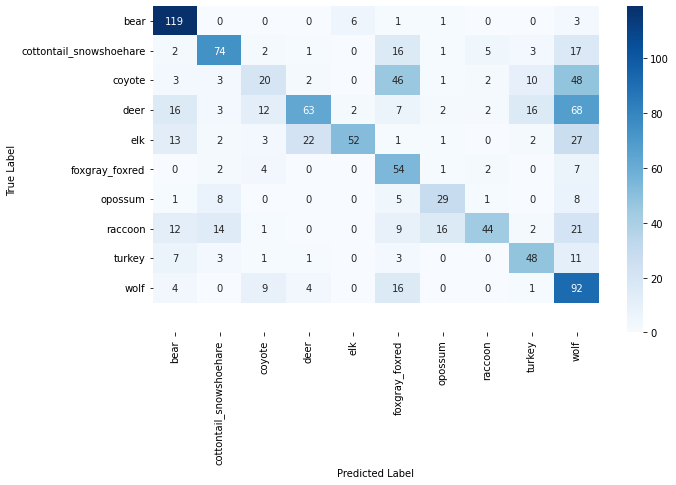

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

index = class_names
columns = class_names

cm = confusion_matrix(test_actuals, test_preds)
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize = (10,6))
ax = sns.heatmap(cm_df, annot = True, fmt='d', cmap = "Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
#ax.get_ylim()
ax.set_ylim(11, 0)

### Top 3 Accuracy

In [ ]:
comparison_df.head()

,image_group_id,top_pred_3,top3_dict_3,top_pred_4,top3_dict_4,topk_conf_3_scaled,topk_conf_4_scaled,event_final_topk_conf,event_final_pred,event_final_pred_conf,Unnamed: 0,TRIGGER_ID,CLASS_SPECIES,Total,CLASS_SPECIES_RESTATED
0,SSWI000000019158997,{'None': 0.0},{},{'cottontail_snowshoehare': 0.6963155269622803},{'cottontail_snowshoehare': '0.696315526962280...,{},{'cottontail_snowshoehare': 0.5802629391352336...,{'cottontail_snowshoehare': 0.5802629391352336...,cottontail_snowshoehare,0.580263,701,SSWI000000019158997,Snowshoe Hare,1,cottontail_snowshoehare
1,SSWI000000012863544,{'None': 0.0},{},{'turkey': 0.8526954650878906},"{'turkey': '0.8526954650878906', 'wolf': '0.12...",{},"{'turkey': 0.7105795542399089, 'wolf': 0.10510...","{'turkey': 0.7105795542399089, 'wolf': 0.10510...",turkey,0.710580,200,SSWI000000012863544,Turkey,1,turkey
2,SSWI000000015060930,{'None': 0.0},{'bear': '0.5193208456039429'},{'foxgray_foxred': 0.2720596492290497},"{'elk': '0.4370231628417969', 'deer': '0.28611...",{'bear': 0.6231850147247314},"{'elk': 0.36418596903483075, 'deer': 0.2384258...","{'bear': 0.6231850147247314, 'elk': 0.36418596...",bear,0.623185,282,SSWI000000015060930,Elk,1,elk
3,SSWI000000020163661,{'cottontail_snowshoehare': 0.41720232367515564},{'cottontail_snowshoehare': '0.417202323675155...,{'turkey': 0.8804661631584167},"{'turkey': '0.8804661631584167', 'wolf': '0.09...",{'cottontail_snowshoehare': 0.5006427884101867...,"{'turkey': 0.733721802632014, 'wolf': 0.076691...","{'turkey': 0.733721802632014, 'cottontail_snow...",turkey,0.733722,986,SSWI000000020163661,Deer,1,deer
4,SSWI000000013549996,{'deer': 0.8169369697570801},"{'coyote': '0.8594738841056824', 'deer': '0.81...",{'wolf': 0.9886847138404846},"{'wolf': '0.9886847138404846', 'coyote': '0.03...","{'coyote': 0.99, 'deer': 0.9803243637084961}","{'wolf': 0.8239039282004039, 'coyote': 0.03056...","{'coyote': 0.99, 'deer': 0.9803243637084961, '...",coyote,0.990000,224,SSWI000000013549996,Wolf,1,wolf


In [ ]:
def check_species_present(x,y):
  if x in y:
    return 1
  else:
    return 0

comparison_df['top3_present'] = comparison_df.apply(lambda x: check_species_present(x.CLASS_SPECIES_RESTATED, x.event_final_topk_conf), axis=1)

In [ ]:
def confirm_top3_species(x, y, z):
  if x == 1:
    ## return top5 pred, which is the true label
    return y
  else:
    ## return top1 pred (probably incorrect pred)
    return z

comparison_df['top3_species_pred'] = comparison_df.apply(lambda x: confirm_top3_species(x.top3_present, x.CLASS_SPECIES_RESTATED, x.event_final_pred), axis=1)

In [ ]:
test_actuals = comparison_df['CLASS_SPECIES_RESTATED'].values
test_preds = comparison_df['top3_species_pred'].values

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_actuals, test_preds, labels=class_names)

array([[126,   0,   0,   0,   1,   1,   1,   0,   0,   1],
       [  1,  95,   2,   0,   0,   9,   1,   3,   3,   7],
       [  3,   1,  86,   0,   0,  22,   0,   0,   8,  15],
       [  8,   2,   6, 116,   1,   7,   2,   1,  12,  36],
       [  4,   2,   3,   7,  95,   1,   1,   0,   1,   9],
       [  0,   1,   1,   0,   0,  65,   0,   0,   0,   3],
       [  1,   3,   0,   0,   0,   2,  42,   0,   0,   4],
       [  5,   9,   0,   0,   0,   6,   5,  75,   2,  17],
       [  3,   1,   1,   1,   0,   0,   0,   0,  65,   3],
       [  1,   0,   2,   0,   0,   4,   0,   0,   0, 119]])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_actuals, test_preds, digits = 4))

                         precision    recall  f1-score   support

                   bear     0.8289    0.9692    0.8936       130
cottontail_snowshoehare     0.8333    0.7851    0.8085       121
                 coyote     0.8515    0.6370    0.7288       135
                   deer     0.9355    0.6073    0.7365       191
                    elk     0.9794    0.7724    0.8636       123
         foxgray_foxred     0.5556    0.9286    0.6952        70
                opossum     0.8077    0.8077    0.8077        52
                raccoon     0.9494    0.6303    0.7576       119
                 turkey     0.7143    0.8784    0.7879        74
                   wolf     0.5561    0.9444    0.7000       126

               accuracy                         0.7748      1141
              macro avg     0.8012    0.7960    0.7779      1141
           weighted avg     0.8234    0.7748    0.7770      1141



(11.0, 0.0)

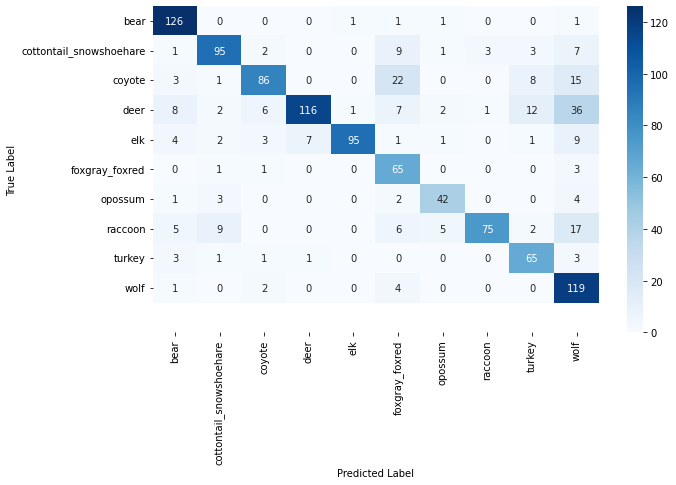

In [ ]:
import seaborn as sns

index = class_names
columns = class_names

cm = confusion_matrix(test_actuals, test_preds)
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize = (10,6))
ax = sns.heatmap(cm_df, annot = True, fmt='d', cmap = "Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
#ax.get_ylim()
ax.set_ylim(11, 0)

## dataframe method (playground)

prioritize yolo classification <br>
fill out top3 classes with efficientnet <br>
(ignore bbox for now) <br>

In [ ]:
## check for blank: SSWI000000005175003
## for playground: SSWI000000013549996
test_df = sample_input[sample_input['image_group_id'] == 'SSWI000000013549996']
test_df

,Unnamed: 0,model_output_id,model_id,image_group_id,image_id_1,image_id_1_species_name,image_id_1_conf,image_id_1_count,image_id_1_blank,image_id_1_detectable,image_id_2,image_id_2_species_name,image_id_2_conf,image_id_2_count,image_id_2_blank,image_id_2_detectable,image_id_3,image_id_3_species_name,image_id_3_conf,image_id_3_count,image_id_3_blank,image_id_3_detectable,load_date,image_id_1_bbox,image_id_2_bbox,image_id_3_bbox
15,15,5016,5,SSWI000000013549996,A,NaN,NaN,1,False,False,B,NaN,NaN,1,False,False,C,NaN,NaN,1,False,False,2021-11-10,"0.8558,0.7205,0.2855,0.2616","0.4317,0.6485,0.205,0.1656","0.4223,0.6498,0.1556,0.1678"
1222,1222,3766,4,SSWI000000013549996,A,"wolf,coyote,deer,bear,turkey","0.9680646061897278,0.02201225608587265,0.00935...",0,False,False,B,"wolf,coyote,turkey,deer,bear","0.9886847138404846,0.010487456806004047,0.0005...",0,False,False,C,"wolf,coyote,deer,turkey,elk","0.9619928002357483,0.03667626157402992,0.00088...",0,False,False,2021-11-10,NaN,NaN,NaN
1274,1274,2516,3,SSWI000000013549996,A,deer,0.7408024072647095,1,False,False,B,coyote,0.8594738841056824,1,False,False,C,deer,0.8169369697570801,1,False,False,2021-11-10,"0.8556231260299683,0.7097264528274536,0.288753...","0.4331307113170624,0.6443768739700317,0.209726...","0.424012154340744,0.6443768739700317,0.1671732..."


In [ ]:
df_model_id3 = test_df[test_df.model_id == 3]
df_model_id4 = test_df[test_df.model_id == 4]
df_model_id5 = test_df[test_df.model_id == 5]
df_model_id5 = df_model_id5[['image_group_id', 'image_id_1_bbox', 'image_id_2_bbox', 'image_id_3_bbox']]

In [ ]:
"""
in any given event, there are 3 images with predictions
for each image, return a dictionary of species and confidence scores

ex:
{'bear': '0.15524305403232574',
 'deer': '0.148423969745636',
 'elk': '0.14720852673053741',
 'foxgray_foxred': '0.0765981450676918',
 'turkey': '0.32857051491737366'}
"""

import math
def create_species_conf_dict(x, y):
  if isinstance(x, float):
    pass
  else:
    species_list = list(x.split(","))
    conf_list = list(y.split(","))
    return dict(zip(species_list, conf_list))


df_model_id3['img1_species_conf_dict'] = df_model_id3.apply(lambda x: create_species_conf_dict(x.image_id_1_species_name, x.image_id_1_conf), axis=1)
df_model_id3['img2_species_conf_dict'] = df_model_id3.apply(lambda x: create_species_conf_dict(x.image_id_2_species_name, x.image_id_2_conf), axis=1)
df_model_id3['img3_species_conf_dict'] = df_model_id3.apply(lambda x: create_species_conf_dict(x.image_id_3_species_name, x.image_id_3_conf), axis=1)

df_model_id4['img1_species_conf_dict'] = df_model_id4.apply(lambda x: create_species_conf_dict(x.image_id_1_species_name, x.image_id_1_conf), axis=1)
df_model_id4['img2_species_conf_dict'] = df_model_id4.apply(lambda x: create_species_conf_dict(x.image_id_2_species_name, x.image_id_2_conf), axis=1)
df_model_id4['img3_species_conf_dict'] = df_model_id4.apply(lambda x: create_species_conf_dict(x.image_id_3_species_name, x.image_id_3_conf), axis=1)

# df_model_id4['img1_species_conf_dict'][1206]

In [ ]:
df_model_id4

,Unnamed: 0,model_output_id,model_id,image_group_id,image_id_1,image_id_1_species_name,image_id_1_conf,image_id_1_count,image_id_1_blank,image_id_1_detectable,image_id_2,image_id_2_species_name,image_id_2_conf,image_id_2_count,image_id_2_blank,image_id_2_detectable,image_id_3,image_id_3_species_name,image_id_3_conf,image_id_3_count,image_id_3_blank,image_id_3_detectable,load_date,image_id_1_bbox,image_id_2_bbox,image_id_3_bbox,img1_species_conf_dict,img2_species_conf_dict,img3_species_conf_dict
1222,1222,3766,4,SSWI000000013549996,A,"wolf,coyote,deer,bear,turkey","0.9680646061897278,0.02201225608587265,0.00935...",0,False,False,B,"wolf,coyote,turkey,deer,bear","0.9886847138404846,0.010487456806004047,0.0005...",0,False,False,C,"wolf,coyote,deer,turkey,elk","0.9619928002357483,0.03667626157402992,0.00088...",0,False,False,2021-11-10,NaN,NaN,NaN,"{'wolf': '0.9680646061897278', 'coyote': '0.02...","{'wolf': '0.9886847138404846', 'coyote': '0.01...","{'wolf': '0.9619928002357483', 'coyote': '0.03..."


In [ ]:
"""
since there are 3 images in an event, each image has a dictionary
for each event, return a combined dictionary of species and list of confidence scores

ex:
{'bear': ['0.15524305403232574', '0.16207468509674072'],
 'coyote': ['0.04405967891216278', '0.050556182861328125'],
 'deer': ['0.148423969745636', '0.2770918905735016'],
 'elk': ['0.14720852673053741', '0.022372109815478325'],
 'foxgray_foxred': ['0.0765981450676918', '0.02164595201611519'],
 'raccoon': ['0.064368836581707'],
 'turkey': ['0.32857051491737366', '0.8158956170082092', '0.31233787536621094'],
 'wolf': ['0.06660380959510803']}
"""



## v2: outputs top1 predictions from each image in the event
def merge_species_conf_dict_top3(x, y, z):

  if x is None:
    x = {'None': 0}
  if y is None:
    y = {'None': 0}
  if z is None:
    z = {'None': 0}
    
  dict_list = [list(x.items())[0],list(y.items())[0],list(z.items())[0]]

  #print(dict_list)
  preds_dict = {}

  for item in dict_list:
    if item is None:
      pass
    else:
      if item[0] in preds_dict:
        preds_dict[item[0]].append(float(item[1]))
      else:
        preds_dict[item[0]] = [float(item[1])]

      
  return preds_dict

df_model_id3['consol_dict'] = df_model_id3.apply(lambda x: merge_species_conf_dict_top3(x.img1_species_conf_dict, x.img2_species_conf_dict, x.img3_species_conf_dict), axis=1)
df_model_id4['consol_dict'] = df_model_id4.apply(lambda x: merge_species_conf_dict_top3(x.img1_species_conf_dict, x.img2_species_conf_dict, x.img3_species_conf_dict), axis=1)

In [ ]:
df_model_id4['consol_dict'][1222]

{'wolf': [0.9680646061897278, 0.9886847138404846, 0.9619928002357483]}

In [ ]:
df_model_id3['consol_dict'][1274]

{'coyote': [0.8594738841056824],
 'deer': [0.7408024072647095, 0.8169369697570801]}

In [ ]:
## case 3
dummy_dict = {
    'coyote': [0.5],
    'deer': [0.7],
    'bear': [0.65]
}

## case 1
dummy_dict = {
    'deer': ['0.7408024072647095', '0.8169369697570801', '0.5']
}

## case 2
dummy_dict = {
    'coyote': ['0.8594738841056824'],
    'deer': ['0.7408024072647095', '0.8169369697570801']
    }

In [ ]:
def get_topk(x, k):
  topk_event_dict = {}
  top_ind = sorted(x, key=x.get, reverse=True)[:k]
  conf_scores = {}
  for i in top_ind:
    conf_scores[i] = max(x[i])
  
  return conf_scores

def get_pred_from_top3(consol_dict):

  ## if all 3 predictions are different classes, defer to class with highest confidence
  if len(consol_dict) == 3:
    return get_topk(consol_dict, 1)

  ## if there is an even number of predictions (2), defer to class with more appearances (has a longer list)
  elif len(consol_dict) == 2:
    max_key = max(consol_dict, key= lambda x: len(set(consol_dict[x])))
    return {max_key: max(consol_dict[max_key])}
  
  ## if there is only one class of predictions, return the class with highest confidence
  else:
    return get_topk(consol_dict, 1)

In [ ]:
df_model_id3['top_pred'] = df_model_id3.apply(lambda x: get_pred_from_top3(x.consol_dict), axis=1)
df_model_id4['top_pred'] = df_model_id4.apply(lambda x: get_pred_from_top3(x.consol_dict), axis=1)

In [ ]:
df_model_id3

,Unnamed: 0,model_output_id,model_id,image_group_id,image_id_1,image_id_1_species_name,image_id_1_conf,image_id_1_count,image_id_1_blank,image_id_1_detectable,image_id_2,image_id_2_species_name,image_id_2_conf,image_id_2_count,image_id_2_blank,image_id_2_detectable,image_id_3,image_id_3_species_name,image_id_3_conf,image_id_3_count,image_id_3_blank,image_id_3_detectable,load_date,image_id_1_bbox,image_id_2_bbox,image_id_3_bbox,img1_species_conf_dict,img2_species_conf_dict,img3_species_conf_dict,consol_dict,top_pred
1274,1274,2516,3,SSWI000000013549996,A,deer,0.7408024072647095,1,False,False,B,coyote,0.8594738841056824,1,False,False,C,deer,0.8169369697570801,1,False,False,2021-11-10,"0.8556231260299683,0.7097264528274536,0.288753...","0.4331307113170624,0.6443768739700317,0.209726...","0.424012154340744,0.6443768739700317,0.1671732...",{'deer': '0.7408024072647095'},{'coyote': '0.8594738841056824'},{'deer': '0.8169369697570801'},"{'deer': [0.7408024072647095, 0.81693696975708...",{'deer': 0.8169369697570801}


In [ ]:
df_model_id4

,Unnamed: 0,model_output_id,model_id,image_group_id,image_id_1,image_id_1_species_name,image_id_1_conf,image_id_1_count,image_id_1_blank,image_id_1_detectable,image_id_2,image_id_2_species_name,image_id_2_conf,image_id_2_count,image_id_2_blank,image_id_2_detectable,image_id_3,image_id_3_species_name,image_id_3_conf,image_id_3_count,image_id_3_blank,image_id_3_detectable,load_date,image_id_1_bbox,image_id_2_bbox,image_id_3_bbox,img1_species_conf_dict,img2_species_conf_dict,img3_species_conf_dict,consol_dict,top_pred
1222,1222,3766,4,SSWI000000013549996,A,"wolf,coyote,deer,bear,turkey","0.9680646061897278,0.02201225608587265,0.00935...",0,False,False,B,"wolf,coyote,turkey,deer,bear","0.9886847138404846,0.010487456806004047,0.0005...",0,False,False,C,"wolf,coyote,deer,turkey,elk","0.9619928002357483,0.03667626157402992,0.00088...",0,False,False,2021-11-10,NaN,NaN,NaN,"{'wolf': '0.9680646061897278', 'coyote': '0.02...","{'wolf': '0.9886847138404846', 'coyote': '0.01...","{'wolf': '0.9619928002357483', 'coyote': '0.03...","{'wolf': [0.9680646061897278, 0.98868471384048...",{'wolf': 0.9886847138404846}


In [ ]:
## generate top3_dict for each model

def merge_species_conf_dict(x, y, z):
  dict_list = [x,y,z]
  #print(dict_list)
  preds_dict = {}

  for item in dict_list:
    if item is None:
      pass
    else:
      for key, value in item.items():
        if key in preds_dict:
          preds_dict[key].append(value)
        else:
          preds_dict[key] = [value]
      
  return preds_dict

df_model_id3['top3_dict'] = df_model_id3.apply(lambda x: get_topk(merge_species_conf_dict(x.img1_species_conf_dict, x.img2_species_conf_dict, x.img3_species_conf_dict),3), axis=1)
df_model_id4['top3_dict'] = df_model_id4.apply(lambda x: get_topk(merge_species_conf_dict(x.img1_species_conf_dict, x.img2_species_conf_dict, x.img3_species_conf_dict),3), axis=1)

In [ ]:
df_model_id3

,Unnamed: 0,model_output_id,model_id,image_group_id,image_id_1,image_id_1_species_name,image_id_1_conf,image_id_1_count,image_id_1_blank,image_id_1_detectable,image_id_2,image_id_2_species_name,image_id_2_conf,image_id_2_count,image_id_2_blank,image_id_2_detectable,image_id_3,image_id_3_species_name,image_id_3_conf,image_id_3_count,image_id_3_blank,image_id_3_detectable,load_date,image_id_1_bbox,image_id_2_bbox,image_id_3_bbox,img1_species_conf_dict,img2_species_conf_dict,img3_species_conf_dict,consol_dict,top_pred,top3_dict
1274,1274,2516,3,SSWI000000013549996,A,deer,0.7408024072647095,1,False,False,B,coyote,0.8594738841056824,1,False,False,C,deer,0.8169369697570801,1,False,False,2021-11-10,"0.8556231260299683,0.7097264528274536,0.288753...","0.4331307113170624,0.6443768739700317,0.209726...","0.424012154340744,0.6443768739700317,0.1671732...",{'deer': '0.7408024072647095'},{'coyote': '0.8594738841056824'},{'deer': '0.8169369697570801'},"{'deer': [0.7408024072647095, 0.81693696975708...",{'deer': 0.8169369697570801},"{'coyote': '0.8594738841056824', 'deer': '0.81..."


In [ ]:
df_model_id4

,Unnamed: 0,model_output_id,model_id,image_group_id,image_id_1,image_id_1_species_name,image_id_1_conf,image_id_1_count,image_id_1_blank,image_id_1_detectable,image_id_2,image_id_2_species_name,image_id_2_conf,image_id_2_count,image_id_2_blank,image_id_2_detectable,image_id_3,image_id_3_species_name,image_id_3_conf,image_id_3_count,image_id_3_blank,image_id_3_detectable,load_date,image_id_1_bbox,image_id_2_bbox,image_id_3_bbox,img1_species_conf_dict,img2_species_conf_dict,img3_species_conf_dict,consol_dict,top_pred,top3_dict
1222,1222,3766,4,SSWI000000013549996,A,"wolf,coyote,deer,bear,turkey","0.9680646061897278,0.02201225608587265,0.00935...",0,False,False,B,"wolf,coyote,turkey,deer,bear","0.9886847138404846,0.010487456806004047,0.0005...",0,False,False,C,"wolf,coyote,deer,turkey,elk","0.9619928002357483,0.03667626157402992,0.00088...",0,False,False,2021-11-10,NaN,NaN,NaN,"{'wolf': '0.9680646061897278', 'coyote': '0.02...","{'wolf': '0.9886847138404846', 'coyote': '0.01...","{'wolf': '0.9619928002357483', 'coyote': '0.03...","{'wolf': [0.9680646061897278, 0.98868471384048...",{'wolf': 0.9886847138404846},"{'wolf': '0.9886847138404846', 'coyote': '0.03..."


In [ ]:
"""
merge model_id3 and model_id4 at the event level
the final prediction dictionaries from both models can be on the same row
"""
df_merge = pd.merge(df_model_id3, df_model_id4, how='inner', on="image_group_id", suffixes=('_3', '_4'))
df_merge

,Unnamed: 0_3,model_output_id_3,model_id_3,image_group_id,image_id_1_3,image_id_1_species_name_3,image_id_1_conf_3,image_id_1_count_3,image_id_1_blank_3,image_id_1_detectable_3,image_id_2_3,image_id_2_species_name_3,image_id_2_conf_3,image_id_2_count_3,image_id_2_blank_3,image_id_2_detectable_3,image_id_3_3,image_id_3_species_name_3,image_id_3_conf_3,image_id_3_count_3,image_id_3_blank_3,image_id_3_detectable_3,load_date_3,image_id_1_bbox_3,image_id_2_bbox_3,image_id_3_bbox_3,img1_species_conf_dict_3,img2_species_conf_dict_3,img3_species_conf_dict_3,consol_dict_3,top_pred_3,top3_dict_3,Unnamed: 0_4,model_output_id_4,model_id_4,image_id_1_4,image_id_1_species_name_4,image_id_1_conf_4,image_id_1_count_4,image_id_1_blank_4,image_id_1_detectable_4,image_id_2_4,image_id_2_species_name_4,image_id_2_conf_4,image_id_2_count_4,image_id_2_blank_4,image_id_2_detectable_4,image_id_3_4,image_id_3_species_name_4,image_id_3_conf_4,image_id_3_count_4,image_id_3_blank_4,image_id_3_detectable_4,load_date_4,image_id_1_bbox_4,image_id_2_bbox_4,image_id_3_bbox_4,img1_species_conf_dict_4,img2_species_conf_dict_4,img3_species_conf_dict_4,consol_dict_4,top_pred_4,top3_dict_4
0,1274,2516,3,SSWI000000013549996,A,deer,0.7408024072647095,1,False,False,B,coyote,0.8594738841056824,1,False,False,C,deer,0.8169369697570801,1,False,False,2021-11-10,"0.8556231260299683,0.7097264528274536,0.288753...","0.4331307113170624,0.6443768739700317,0.209726...","0.424012154340744,0.6443768739700317,0.1671732...",{'deer': '0.7408024072647095'},{'coyote': '0.8594738841056824'},{'deer': '0.8169369697570801'},"{'deer': [0.7408024072647095, 0.81693696975708...",{'deer': 0.8169369697570801},"{'coyote': '0.8594738841056824', 'deer': '0.81...",1222,3766,4,A,"wolf,coyote,deer,bear,turkey","0.9680646061897278,0.02201225608587265,0.00935...",0,False,False,B,"wolf,coyote,turkey,deer,bear","0.9886847138404846,0.010487456806004047,0.0005...",0,False,False,C,"wolf,coyote,deer,turkey,elk","0.9619928002357483,0.03667626157402992,0.00088...",0,False,False,2021-11-10,NaN,NaN,NaN,"{'wolf': '0.9680646061897278', 'coyote': '0.02...","{'wolf': '0.9886847138404846', 'coyote': '0.01...","{'wolf': '0.9619928002357483', 'coyote': '0.03...","{'wolf': [0.9680646061897278, 0.98868471384048...",{'wolf': 0.9886847138404846},"{'wolf': '0.9886847138404846', 'coyote': '0.03..."


In [ ]:
"""
clean-up columns
"""
df_merge = df_merge[['image_group_id', 'top_pred_3', 'top3_dict_3', 'top_pred_4', 'top3_dict_4']]
df_merge

,image_group_id,top_pred_3,top3_dict_3,top_pred_4,top3_dict_4
0,SSWI000000013549996,{'deer': 0.8169369697570801},"{'coyote': '0.8594738841056824', 'deer': '0.81...",{'wolf': 0.9886847138404846},"{'wolf': '0.9886847138404846', 'coyote': '0.03..."


In [ ]:
"""
before we combine scores, we should weight the predictions between model_id3 and model_id4
to slightly bias the scores towards model_id3

80/67 = 1.2

multiply topk_conf_3 by 1.2
divide topk_conf_4 by 1.2
"""

def scale_model_id3(x):
  ## x is a dictionary
  intermed_dict = {key: float(value) * 1.2 for key, value in x.items()}
  ## cap maximum possible score at 0.99
  output_dict = {key: (0.99 if float(value) > 1 else float(value)) for key, value in intermed_dict.items()}
  return output_dict

def scale_model_id4(x):
  ## x is a dictionary
  return {key: float(value) / 1.2 for key, value in x.items()}

df_merge['topk_conf_3_scaled'] = df_merge.apply(lambda x: scale_model_id3(x.top3_dict_3), axis=1)
df_merge['topk_conf_4_scaled'] = df_merge.apply(lambda x: scale_model_id4(x.top3_dict_4), axis=1)

In [ ]:
df_merge

,image_group_id,top_pred_3,top3_dict_3,top_pred_4,top3_dict_4,topk_conf_3_scaled,topk_conf_4_scaled
0,SSWI000000013549996,{'deer': 0.8169369697570801},"{'coyote': '0.8594738841056824', 'deer': '0.81...",{'wolf': 0.9886847138404846},"{'wolf': '0.9886847138404846', 'coyote': '0.03...","{'coyote': 0.99, 'deer': 0.9803243637084961}","{'wolf': 0.8239039282004039, 'coyote': 0.03056..."


In [ ]:
"""
output final topk dictionary of species predictions and their confidence scores
"""

def combine_topk_conf(x, y):
  dict_list = [x,y]
  #print(dict_list)
  preds_dict = {}

  for item in dict_list:
    if item is None:
      pass
    else:
      for key, value in item.items():
        if key in preds_dict:
          preds_dict[key].append(value)
        else:
          preds_dict[key] = [value]
      
  return preds_dict

def get_final_topk(x, k):
  topk_event_dict = {}
  top_ind = sorted(x, key=x.get, reverse=True)[:k]
  conf_scores = {}
  for i in top_ind:
    conf_scores[i] = max(x[i])
  
  return conf_scores

df_merge['event_final_topk_conf'] = df_merge.apply(lambda x: get_final_topk(combine_topk_conf(x.topk_conf_3_scaled, x.topk_conf_4_scaled),3), axis=1)
df_merge['event_final_topk_conf'][0]

{'coyote': 0.99, 'deer': 0.9803243637084961, 'wolf': 0.8239039282004039}

In [ ]:
## confirm top3
print("{}\n{}".format(df_merge['topk_conf_4_scaled'][0], df_merge['topk_conf_3_scaled'][0]))

{'wolf': 0.8239039282004039, 'coyote': 0.030563551311691604, 'deer': 0.007793215724329154}
{'coyote': 0.99, 'deer': 0.9803243637084961}


In [ ]:
df_merge

,image_group_id,top_pred_3,top3_dict_3,top_pred_4,top3_dict_4,topk_conf_3_scaled,topk_conf_4_scaled,event_final_topk_conf
0,SSWI000000013549996,{'deer': 0.8169369697570801},"{'coyote': '0.8594738841056824', 'deer': '0.81...",{'wolf': 0.9886847138404846},"{'wolf': '0.9886847138404846', 'coyote': '0.03...","{'coyote': 0.99, 'deer': 0.9803243637084961}","{'wolf': 0.8239039282004039, 'coyote': 0.03056...","{'coyote': 0.99, 'deer': 0.9803243637084961, '..."


In [ ]:
"""
output final event prediction, conf score, and bbox
"""
def output_final_pred_species(x):
  intermed_dict = {key: float(value) for key, value in x.items()}
  top_ind = sorted(intermed_dict, key=intermed_dict.get, reverse=True)[:1]
  #print(top_ind)
  return top_ind[0]

df_merge['event_final_pred'] = df_merge.apply(lambda x: output_final_pred_species(x.event_final_topk_conf), axis=1)
df_merge['event_final_pred_conf'] = df_merge.apply(lambda x: output_final_pred_conf(x.event_final_topk_conf), axis=1)
df_merge

,image_group_id,top_pred_3,top3_dict_3,top_pred_4,top3_dict_4,topk_conf_3_scaled,topk_conf_4_scaled,event_final_topk_conf,event_final_pred,event_final_pred_conf
0,SSWI000000013549996,{'deer': 0.8169369697570801},"{'coyote': '0.8594738841056824', 'deer': '0.81...",{'wolf': 0.9886847138404846},"{'wolf': '0.9886847138404846', 'coyote': '0.03...","{'coyote': 0.99, 'deer': 0.9803243637084961}","{'wolf': 0.8239039282004039, 'coyote': 0.03056...","{'coyote': 0.99, 'deer': 0.9803243637084961, '...",coyote,0.99


## ignore

In [ ]:
### get top 5 for each event
"""
for each event, consolidate the combined dictionary to output a topk result by confidence scores

ex:
k = 5
{'bear': '0.16207468509674072',
 'deer': '0.2770918905735016',
 'elk': '0.14720852673053741',
 'foxgray_foxred': '0.0765981450676918',
 'turkey': '0.8158956170082092'}
"""

def get_topk(x, k):
  topk_event_dict = {}
  top_ind = sorted(x, key=x.get, reverse=True)[:k]
  conf_scores = {}
  for i in top_ind:
    conf_scores[i] = max(x[i])
  
  return conf_scores

df_model_id3['topk_conf'] = df_model_id3.apply(lambda x: get_topk(x.consol_dict, 5), axis=1)
df_model_id4['topk_conf'] = df_model_id4.apply(lambda x: get_topk(x.consol_dict, 5), axis=1)
#df_model_id4['topk_conf'][1206]

In [ ]:
print(df_model_id3['topk_conf'][1274])
print(df_model_id4['topk_conf'][1222])

{'coyote': '0.8594738841056824', 'deer': '0.8169369697570801'}
{'wolf': '0.9886847138404846', 'coyote': '0.03667626157402992', 'deer': '0.009351858869194984', 'bear': '6.45634499960579e-05', 'turkey': '0.000521707464940846'}


In [ ]:
"""
output final prediction based on highest confidence: class and corresponding confidence score
"""

def output_final_pred_species(x):
  intermed_dict = {key: float(value) for key, value in x.items()}
  top_ind = sorted(intermed_dict, key=intermed_dict.get, reverse=True)[:1]
  #print(top_ind)
  return top_ind[0]

def output_final_pred_conf(x):
  intermed_dict = {key: float(value) for key, value in x.items()}
  top_ind = sorted(intermed_dict, key=intermed_dict.get, reverse=True)[:1]
  #print(top_ind)
  return x[top_ind[0]]

df_model_id4['final_pred'] = df_model_id4.apply(lambda x: output_final_pred_species(x.topk_conf), axis=1)
df_model_id4['final_pred_conf'] = df_model_id4.apply(lambda x: output_final_pred_conf(x.topk_conf), axis=1)

df_model_id3['final_pred'] = df_model_id3.apply(lambda x: output_final_pred_species(x.topk_conf), axis=1)
df_model_id3['final_pred_conf'] = df_model_id3.apply(lambda x: output_final_pred_conf(x.topk_conf), axis=1)

df_model_id4

,Unnamed: 0,model_output_id,model_id,image_group_id,image_id_1,image_id_1_species_name,image_id_1_conf,image_id_1_count,image_id_1_blank,image_id_1_detectable,image_id_2,image_id_2_species_name,image_id_2_conf,image_id_2_count,image_id_2_blank,image_id_2_detectable,image_id_3,image_id_3_species_name,image_id_3_conf,image_id_3_count,image_id_3_blank,image_id_3_detectable,load_date,image_id_1_bbox,image_id_2_bbox,image_id_3_bbox,img1_species_conf_dict,img2_species_conf_dict,img3_species_conf_dict,consol_dict,topk_conf,final_pred,final_pred_conf
1222,1222,3766,4,SSWI000000013549996,A,"wolf,coyote,deer,bear,turkey","0.9680646061897278,0.02201225608587265,0.00935...",0,False,False,B,"wolf,coyote,turkey,deer,bear","0.9886847138404846,0.010487456806004047,0.0005...",0,False,False,C,"wolf,coyote,deer,turkey,elk","0.9619928002357483,0.03667626157402992,0.00088...",0,False,False,2021-11-10,NaN,NaN,NaN,"{'wolf': '0.9680646061897278', 'coyote': '0.02...","{'wolf': '0.9886847138404846', 'coyote': '0.01...","{'wolf': '0.9619928002357483', 'coyote': '0.03...","{'wolf': ['0.9680646061897278', '0.98868471384...","{'wolf': '0.9886847138404846', 'coyote': '0.03...",wolf,0.9886847138404846


In [ ]:
df_model_id3

,Unnamed: 0,model_output_id,model_id,image_group_id,image_id_1,image_id_1_species_name,image_id_1_conf,image_id_1_count,image_id_1_blank,image_id_1_detectable,image_id_2,image_id_2_species_name,image_id_2_conf,image_id_2_count,image_id_2_blank,image_id_2_detectable,image_id_3,image_id_3_species_name,image_id_3_conf,image_id_3_count,image_id_3_blank,image_id_3_detectable,load_date,image_id_1_bbox,image_id_2_bbox,image_id_3_bbox,img1_species_conf_dict,img2_species_conf_dict,img3_species_conf_dict,consol_dict,topk_conf,final_pred,final_pred_conf
1274,1274,2516,3,SSWI000000013549996,A,deer,0.7408024072647095,1,False,False,B,coyote,0.8594738841056824,1,False,False,C,deer,0.8169369697570801,1,False,False,2021-11-10,"0.8556231260299683,0.7097264528274536,0.288753...","0.4331307113170624,0.6443768739700317,0.209726...","0.424012154340744,0.6443768739700317,0.1671732...",{'deer': '0.7408024072647095'},{'coyote': '0.8594738841056824'},{'deer': '0.8169369697570801'},"{'deer': ['0.7408024072647095', '0.81693696975...","{'coyote': '0.8594738841056824', 'deer': '0.81...",coyote,0.8594738841056824


In [ ]:
"""
based on the resulting class, get the corresponding bbox
"""

def get_bbox_imgNo(pred_class, pred_conf, img1_conf_dict, img2_conf_dict, img3_conf_dict):

  key, value = pred_class, pred_conf
  if key in img1_conf_dict and value == img1_conf_dict[key]:
    return "img1"
  elif key in img2_conf_dict and value == img2_conf_dict[key]:
    return "img2"
  else:
    return "img3"

def get_bbox(x, img1_bbox, img2_bbox, img3_bbox):
  if x == "img1":
    return img1_bbox
  elif x == "img2":
    return img2_bbox
  else:
    return img3_bbox

df_model_id3['bbox_img'] = df_model_id3.apply(lambda x: get_bbox(get_bbox_imgNo(x.final_pred, x.final_pred_conf, x.img1_species_conf_dict, x.img2_species_conf_dict,
                                                                        x.img3_species_conf_dict), x.image_id_1_bbox, x.image_id_2_bbox, x.image_id_3_bbox), axis=1)

df_model_id3

,Unnamed: 0,model_output_id,model_id,image_group_id,image_id_1,image_id_1_species_name,image_id_1_conf,image_id_1_count,image_id_1_blank,image_id_1_detectable,image_id_2,image_id_2_species_name,image_id_2_conf,image_id_2_count,image_id_2_blank,image_id_2_detectable,image_id_3,image_id_3_species_name,image_id_3_conf,image_id_3_count,image_id_3_blank,image_id_3_detectable,load_date,image_id_1_bbox,image_id_2_bbox,image_id_3_bbox,img1_species_conf_dict,img2_species_conf_dict,img3_species_conf_dict,consol_dict,topk_conf,final_pred,final_pred_conf,bbox_img
1274,1274,2516,3,SSWI000000013549996,A,deer,0.7408024072647095,1,False,False,B,coyote,0.8594738841056824,1,False,False,C,deer,0.8169369697570801,1,False,False,2021-11-10,"0.8556231260299683,0.7097264528274536,0.288753...","0.4331307113170624,0.6443768739700317,0.209726...","0.424012154340744,0.6443768739700317,0.1671732...",{'deer': '0.7408024072647095'},{'coyote': '0.8594738841056824'},{'deer': '0.8169369697570801'},"{'deer': ['0.7408024072647095', '0.81693696975...","{'coyote': '0.8594738841056824', 'deer': '0.81...",coyote,0.8594738841056824,"0.4331307113170624,0.6443768739700317,0.209726..."


In [ ]:
## join model_id4 with model_id5 first
df_model_id4 = pd.merge(df_model_id4, df_model_id5, how="inner", on="image_group_id", suffixes=('_4', '_5'))

df_model_id4['bbox_img'] = df_model_id4.apply(lambda x: get_bbox(get_bbox_imgNo(x.final_pred, x.final_pred_conf, x.img1_species_conf_dict, x.img2_species_conf_dict,
                                                                                x.img3_species_conf_dict), x.image_id_1_bbox_5, x.image_id_2_bbox_5, x.image_id_3_bbox_5), axis=1)

df_model_id4

,Unnamed: 0,model_output_id,model_id,image_group_id,image_id_1,image_id_1_species_name,image_id_1_conf,image_id_1_count,image_id_1_blank,image_id_1_detectable,image_id_2,image_id_2_species_name,image_id_2_conf,image_id_2_count,image_id_2_blank,image_id_2_detectable,image_id_3,image_id_3_species_name,image_id_3_conf,image_id_3_count,image_id_3_blank,image_id_3_detectable,load_date,image_id_1_bbox_4,image_id_2_bbox_4,image_id_3_bbox_4,img1_species_conf_dict,img2_species_conf_dict,img3_species_conf_dict,consol_dict,topk_conf,final_pred,final_pred_conf,image_id_1_bbox_5,image_id_2_bbox_5,image_id_3_bbox_5,bbox_img
0,1222,3766,4,SSWI000000013549996,A,"wolf,coyote,deer,bear,turkey","0.9680646061897278,0.02201225608587265,0.00935...",0,False,False,B,"wolf,coyote,turkey,deer,bear","0.9886847138404846,0.010487456806004047,0.0005...",0,False,False,C,"wolf,coyote,deer,turkey,elk","0.9619928002357483,0.03667626157402992,0.00088...",0,False,False,2021-11-10,NaN,NaN,NaN,"{'wolf': '0.9680646061897278', 'coyote': '0.02...","{'wolf': '0.9886847138404846', 'coyote': '0.01...","{'wolf': '0.9619928002357483', 'coyote': '0.03...","{'wolf': ['0.9680646061897278', '0.98868471384...","{'wolf': '0.9886847138404846', 'coyote': '0.03...",wolf,0.9886847138404846,"0.8558,0.7205,0.2855,0.2616","0.4317,0.6485,0.205,0.1656","0.4223,0.6498,0.1556,0.1678","0.4317,0.6485,0.205,0.1656"


In [ ]:
"""
merge model_id3 and model_id4 at the event level
the final prediction dictionaries from both models can be on the same row
"""
df_merge = pd.merge(df_model_id3, df_model_id4, how='inner', on="image_group_id", suffixes=('_3', '_4'))
df_merge

,Unnamed: 0_3,model_output_id_3,model_id_3,image_group_id,image_id_1_3,image_id_1_species_name_3,image_id_1_conf_3,image_id_1_count_3,image_id_1_blank_3,image_id_1_detectable_3,image_id_2_3,image_id_2_species_name_3,image_id_2_conf_3,image_id_2_count_3,image_id_2_blank_3,image_id_2_detectable_3,image_id_3_3,image_id_3_species_name_3,image_id_3_conf_3,image_id_3_count_3,image_id_3_blank_3,image_id_3_detectable_3,load_date_3,image_id_1_bbox,image_id_2_bbox,image_id_3_bbox,img1_species_conf_dict_3,img2_species_conf_dict_3,img3_species_conf_dict_3,consol_dict_3,topk_conf_3,final_pred_3,final_pred_conf_3,bbox_img_3,Unnamed: 0_4,model_output_id_4,model_id_4,image_id_1_4,image_id_1_species_name_4,image_id_1_conf_4,image_id_1_count_4,image_id_1_blank_4,image_id_1_detectable_4,image_id_2_4,image_id_2_species_name_4,image_id_2_conf_4,image_id_2_count_4,image_id_2_blank_4,image_id_2_detectable_4,image_id_3_4,image_id_3_species_name_4,image_id_3_conf_4,image_id_3_count_4,image_id_3_blank_4,image_id_3_detectable_4,load_date_4,image_id_1_bbox_4,image_id_2_bbox_4,image_id_3_bbox_4,img1_species_conf_dict_4,img2_species_conf_dict_4,img3_species_conf_dict_4,consol_dict_4,topk_conf_4,final_pred_4,final_pred_conf_4,image_id_1_bbox_5,image_id_2_bbox_5,image_id_3_bbox_5,bbox_img_4
0,1274,2516,3,SSWI000000013549996,A,deer,0.7408024072647095,1,False,False,B,coyote,0.8594738841056824,1,False,False,C,deer,0.8169369697570801,1,False,False,2021-11-10,"0.8556231260299683,0.7097264528274536,0.288753...","0.4331307113170624,0.6443768739700317,0.209726...","0.424012154340744,0.6443768739700317,0.1671732...",{'deer': '0.7408024072647095'},{'coyote': '0.8594738841056824'},{'deer': '0.8169369697570801'},"{'deer': ['0.7408024072647095', '0.81693696975...","{'coyote': '0.8594738841056824', 'deer': '0.81...",coyote,0.8594738841056824,"0.4331307113170624,0.6443768739700317,0.209726...",1222,3766,4,A,"wolf,coyote,deer,bear,turkey","0.9680646061897278,0.02201225608587265,0.00935...",0,False,False,B,"wolf,coyote,turkey,deer,bear","0.9886847138404846,0.010487456806004047,0.0005...",0,False,False,C,"wolf,coyote,deer,turkey,elk","0.9619928002357483,0.03667626157402992,0.00088...",0,False,False,2021-11-10,NaN,NaN,NaN,"{'wolf': '0.9680646061897278', 'coyote': '0.02...","{'wolf': '0.9886847138404846', 'coyote': '0.01...","{'wolf': '0.9619928002357483', 'coyote': '0.03...","{'wolf': ['0.9680646061897278', '0.98868471384...","{'wolf': '0.9886847138404846', 'coyote': '0.03...",wolf,0.9886847138404846,"0.8558,0.7205,0.2855,0.2616","0.4317,0.6485,0.205,0.1656","0.4223,0.6498,0.1556,0.1678","0.4317,0.6485,0.205,0.1656"


In [ ]:
df_merge

,Unnamed: 0_3,model_output_id_3,model_id_3,image_group_id,image_id_1_3,image_id_1_species_name_3,image_id_1_conf_3,image_id_1_count_3,image_id_1_blank_3,image_id_1_detectable_3,image_id_2_3,image_id_2_species_name_3,image_id_2_conf_3,image_id_2_count_3,image_id_2_blank_3,image_id_2_detectable_3,image_id_3_3,image_id_3_species_name_3,image_id_3_conf_3,image_id_3_count_3,image_id_3_blank_3,image_id_3_detectable_3,load_date_3,image_id_1_bbox,image_id_2_bbox,image_id_3_bbox,img1_species_conf_dict_3,img2_species_conf_dict_3,img3_species_conf_dict_3,consol_dict_3,topk_conf_3,final_pred_3,final_pred_conf_3,bbox_img_3,Unnamed: 0_4,model_output_id_4,model_id_4,image_id_1_4,image_id_1_species_name_4,image_id_1_conf_4,image_id_1_count_4,image_id_1_blank_4,image_id_1_detectable_4,image_id_2_4,image_id_2_species_name_4,image_id_2_conf_4,image_id_2_count_4,image_id_2_blank_4,image_id_2_detectable_4,image_id_3_4,image_id_3_species_name_4,image_id_3_conf_4,image_id_3_count_4,image_id_3_blank_4,image_id_3_detectable_4,load_date_4,image_id_1_bbox_4,image_id_2_bbox_4,image_id_3_bbox_4,img1_species_conf_dict_4,img2_species_conf_dict_4,img3_species_conf_dict_4,consol_dict_4,topk_conf_4,final_pred_4,final_pred_conf_4,image_id_1_bbox_5,image_id_2_bbox_5,image_id_3_bbox_5,bbox_img_4
0,1274,2516,3,SSWI000000013549996,A,deer,0.7408024072647095,1,False,False,B,coyote,0.8594738841056824,1,False,False,C,deer,0.8169369697570801,1,False,False,2021-11-10,"0.8556231260299683,0.7097264528274536,0.288753...","0.4331307113170624,0.6443768739700317,0.209726...","0.424012154340744,0.6443768739700317,0.1671732...",{'deer': '0.7408024072647095'},{'coyote': '0.8594738841056824'},{'deer': '0.8169369697570801'},"{'deer': ['0.7408024072647095', '0.81693696975...","{'coyote': '0.8594738841056824', 'deer': '0.81...",coyote,0.8594738841056824,"0.4331307113170624,0.6443768739700317,0.209726...",1222,3766,4,A,"wolf,coyote,deer,bear,turkey","0.9680646061897278,0.02201225608587265,0.00935...",0,False,False,B,"wolf,coyote,turkey,deer,bear","0.9886847138404846,0.010487456806004047,0.0005...",0,False,False,C,"wolf,coyote,deer,turkey,elk","0.9619928002357483,0.03667626157402992,0.00088...",0,False,False,2021-11-10,NaN,NaN,NaN,"{'wolf': '0.9680646061897278', 'coyote': '0.02...","{'wolf': '0.9886847138404846', 'coyote': '0.01...","{'wolf': '0.9619928002357483', 'coyote': '0.03...","{'wolf': ['0.9680646061897278', '0.98868471384...","{'wolf': '0.9886847138404846', 'coyote': '0.03...",wolf,0.9886847138404846,"0.8558,0.7205,0.2855,0.2616","0.4317,0.6485,0.205,0.1656","0.4223,0.6498,0.1556,0.1678","0.4317,0.6485,0.205,0.1656"


In [ ]:
"""
clean-up columns
"""
df_merge = df_merge[['image_group_id', 'image_id_1_bbox', 'image_id_2_bbox', 'image_id_3_bbox', 'topk_conf_3', 'final_pred_3', 'final_pred_conf_3', 
                     'img1_species_conf_dict_3', 'img2_species_conf_dict_3', 'img3_species_conf_dict_3', 
                     'image_id_1_bbox_4', 'image_id_2_bbox_4', 'image_id_3_bbox_4', 'topk_conf_4', 'final_pred_4', 'final_pred_conf_4',
                     'img1_species_conf_dict_4', 'img2_species_conf_dict_4', 'img3_species_conf_dict_4',
                     'image_id_1_bbox_5', 'image_id_2_bbox_5', 'image_id_3_bbox_5', 'bbox_img_4']]
df_merge = df_merge.rename(columns={'image_id_1_bbox':'image_id_1_bbox_3', 'image_id_2_bbox':'image_id_2_bbox_3', 'image_id_3_bbox':'image_id_3_bbox_3'})    
df_merge

,image_group_id,image_id_1_bbox_3,image_id_2_bbox_3,image_id_3_bbox_3,topk_conf_3,final_pred_3,final_pred_conf_3,img1_species_conf_dict_3,img2_species_conf_dict_3,img3_species_conf_dict_3,image_id_1_bbox_4,image_id_2_bbox_4,image_id_3_bbox_4,topk_conf_4,final_pred_4,final_pred_conf_4,img1_species_conf_dict_4,img2_species_conf_dict_4,img3_species_conf_dict_4,image_id_1_bbox_5,image_id_2_bbox_5,image_id_3_bbox_5,bbox_img_4
0,SSWI000000013549996,"0.8556231260299683,0.7097264528274536,0.288753...","0.4331307113170624,0.6443768739700317,0.209726...","0.424012154340744,0.6443768739700317,0.1671732...","{'coyote': '0.8594738841056824', 'deer': '0.81...",coyote,0.8594738841056824,{'deer': '0.7408024072647095'},{'coyote': '0.8594738841056824'},{'deer': '0.8169369697570801'},NaN,NaN,NaN,"{'wolf': '0.9886847138404846', 'coyote': '0.03...",wolf,0.9886847138404846,"{'wolf': '0.9680646061897278', 'coyote': '0.02...","{'wolf': '0.9886847138404846', 'coyote': '0.01...","{'wolf': '0.9619928002357483', 'coyote': '0.03...","0.8558,0.7205,0.2855,0.2616","0.4317,0.6485,0.205,0.1656","0.4223,0.6498,0.1556,0.1678","0.4317,0.6485,0.205,0.1656"


In [ ]:
# """
# cleanup columns
# """
# df_merge = df_merge.drop(columns=['Unnamed: 0_3','model_output_id_3', 'image_id_1_3', 'image_id_1_species_name_3', 'image_id_1_conf_3', 'image_id_1_count_3',
#                        'image_id_1_blank_3', 'image_id_1_detectable_3', 'image_id_2_3', 'image_id_2_species_name_3', 'image_id_2_conf_3',
#                        'image_id_2_count_3', 'image_id_2_blank_3', 'image_id_2_detectable_3', 'image_id_3_3', 'image_id_3_species_name_3',
#                        'image_id_3_conf_3', 'image_id_3_count_3', 'image_id_3_blank_3', 'image_id_3_detectable_3', 'load_date_3', 'img1_species_conf_dict_3',
#                        'img2_species_conf_dict_3', 'img3_species_conf_dict_3', 'consol_dict_3',
#                        'Unnamed: 0_4', 'model_output_id_4', 'image_id_1_4', 'image_id_1_species_name_4', 'image_id_1_conf_4', 'image_id_1_count_4',
#                        'image_id_1_blank_4', 'image_id_1_detectable_4', 'image_id_2_4', 'image_id_2_species_name_4', 'image_id_2_conf_4',
#                        'image_id_2_count_4', 'image_id_2_blank_4', 'image_id_2_detectable_4', 'image_id_3_4', 'image_id_3_species_name_4',
#                        'image_id_3_conf_4', 'image_id_3_count_4', 'image_id_3_blank_4', 'image_id_3_detectable_4', 'load_date_4', 'img1_species_conf_dict_4',
#                        'img2_species_conf_dict_4', 'img3_species_conf_dict_4', 'consol_dict_4'])
# df_merge

In [ ]:
"""
before we combine scores, we should weight the predictions between model_id3 and model_id4
to slightly bias the scores towards model_id3

80/67 = 1.2

multiply topk_conf_3 by 1.2
divide topk_conf_4 by 1.2
"""

def scale_model_id3(x):
  ## x is a dictionary
  intermed_dict = {key: float(value) * 1.2 for key, value in x.items()}
  ## cap maximum possible score at 0.99
  output_dict = {key: (0.99 if float(value) > 1 else float(value)) for key, value in intermed_dict.items()}
  return output_dict

def scale_model_id4(x):
  ## x is a dictionary
  return {key: float(value) / 1.2 for key, value in x.items()}

df_merge['topk_conf_3_scaled'] = df_merge.apply(lambda x: scale_model_id3(x.topk_conf_3), axis=1)
df_merge['topk_conf_4_scaled'] = df_merge.apply(lambda x: scale_model_id4(x.topk_conf_4), axis=1)

In [ ]:
"""
output final topk dictionary of species predictions and their confidence scores
"""

def combine_topk_conf(x, y):
  dict_list = [x,y]
  #print(dict_list)
  preds_dict = {}

  for item in dict_list:
    if item is None:
      pass
    else:
      for key, value in item.items():
        if key in preds_dict:
          preds_dict[key].append(value)
        else:
          preds_dict[key] = [value]
      
  return preds_dict

def get_final_topk(x, k):
  topk_event_dict = {}
  top_ind = sorted(x, key=x.get, reverse=True)[:k]
  conf_scores = {}
  for i in top_ind:
    conf_scores[i] = max(x[i])
  
  return conf_scores

df_merge['event_final_topk_conf'] = df_merge.apply(lambda x: get_final_topk(combine_topk_conf(x.topk_conf_3_scaled, x.topk_conf_4_scaled),3), axis=1)
df_merge['event_final_topk_conf'][0]

{'coyote': 0.99, 'deer': 0.9803243637084961, 'wolf': 0.8239039282004039}

In [ ]:
## confirm top3
print("{}\n{}".format(df_merge['topk_conf_4_scaled'][0], df_merge['topk_conf_3_scaled'][0]))

{'wolf': 0.8239039282004039, 'coyote': 0.030563551311691604, 'deer': 0.007793215724329154, 'bear': 5.380287499671492e-05, 'turkey': 0.0004347562207840383}
{'coyote': 0.99, 'deer': 0.9803243637084961}


In [ ]:
df_merge

,image_group_id,image_id_1_bbox_3,image_id_2_bbox_3,image_id_3_bbox_3,topk_conf_3,final_pred_3,final_pred_conf_3,img1_species_conf_dict_3,img2_species_conf_dict_3,img3_species_conf_dict_3,image_id_1_bbox_4,image_id_2_bbox_4,image_id_3_bbox_4,topk_conf_4,final_pred_4,final_pred_conf_4,img1_species_conf_dict_4,img2_species_conf_dict_4,img3_species_conf_dict_4,image_id_1_bbox_5,image_id_2_bbox_5,image_id_3_bbox_5,bbox_img_4,topk_conf_3_scaled,topk_conf_4_scaled,event_final_topk_conf
0,SSWI000000013549996,"0.8556231260299683,0.7097264528274536,0.288753...","0.4331307113170624,0.6443768739700317,0.209726...","0.424012154340744,0.6443768739700317,0.1671732...","{'coyote': '0.8594738841056824', 'deer': '0.81...",coyote,0.8594738841056824,{'deer': '0.7408024072647095'},{'coyote': '0.8594738841056824'},{'deer': '0.8169369697570801'},NaN,NaN,NaN,"{'wolf': '0.9886847138404846', 'coyote': '0.03...",wolf,0.9886847138404846,"{'wolf': '0.9680646061897278', 'coyote': '0.02...","{'wolf': '0.9886847138404846', 'coyote': '0.01...","{'wolf': '0.9619928002357483', 'coyote': '0.03...","0.8558,0.7205,0.2855,0.2616","0.4317,0.6485,0.205,0.1656","0.4223,0.6498,0.1556,0.1678","0.4317,0.6485,0.205,0.1656","{'coyote': 0.99, 'deer': 0.9803243637084961}","{'wolf': 0.8239039282004039, 'coyote': 0.03056...","{'coyote': 0.99, 'deer': 0.9803243637084961, '..."


In [ ]:
"""
output final event prediction, conf score, and bbox
"""
def output_final_pred_species(x):
  intermed_dict = {key: float(value) for key, value in x.items()}
  top_ind = sorted(intermed_dict, key=intermed_dict.get, reverse=True)[:1]
  #print(top_ind)
  return top_ind[0]

def get_bbox_imgNo(pred_class, pred_conf, img1_conf_dict, img2_conf_dict, img3_conf_dict):

  key, value = pred_class, pred_conf
  if key in img1_conf_dict and value == img1_conf_dict[key]:
    return "img1"
  elif key in img2_conf_dict and value == img2_conf_dict[key]:
    return "img2"
  else:
    return "img3"

def get_bbox(x, img1_bbox, img2_bbox, img3_bbox):
  if x == "img1":
    return img1_bbox
  elif x == "img2":
    return img2_bbox
  else:
    return img3_bbox

df_merge['event_final_pred'] = df_merge.apply(lambda x: output_final_pred_species(x.event_final_topk_conf), axis=1)
df_merge['event_final_pred_conf'] = df_merge.apply(lambda x: output_final_pred_conf(x.event_final_topk_conf), axis=1)
df_merge

,image_group_id,image_id_1_bbox_3,image_id_2_bbox_3,image_id_3_bbox_3,topk_conf_3,final_pred_3,final_pred_conf_3,img1_species_conf_dict_3,img2_species_conf_dict_3,img3_species_conf_dict_3,image_id_1_bbox_4,image_id_2_bbox_4,image_id_3_bbox_4,topk_conf_4,final_pred_4,final_pred_conf_4,img1_species_conf_dict_4,img2_species_conf_dict_4,img3_species_conf_dict_4,image_id_1_bbox_5,image_id_2_bbox_5,image_id_3_bbox_5,bbox_img_4,topk_conf_3_scaled,topk_conf_4_scaled,event_final_topk_conf,event_final_pred,event_final_pred_conf
0,SSWI000000013549996,"0.8556231260299683,0.7097264528274536,0.288753...","0.4331307113170624,0.6443768739700317,0.209726...","0.424012154340744,0.6443768739700317,0.1671732...","{'coyote': '0.8594738841056824', 'deer': '0.81...",coyote,0.8594738841056824,{'deer': '0.7408024072647095'},{'coyote': '0.8594738841056824'},{'deer': '0.8169369697570801'},NaN,NaN,NaN,"{'wolf': '0.9886847138404846', 'coyote': '0.03...",wolf,0.9886847138404846,"{'wolf': '0.9680646061897278', 'coyote': '0.02...","{'wolf': '0.9886847138404846', 'coyote': '0.01...","{'wolf': '0.9619928002357483', 'coyote': '0.03...","0.8558,0.7205,0.2855,0.2616","0.4317,0.6485,0.205,0.1656","0.4223,0.6498,0.1556,0.1678","0.4317,0.6485,0.205,0.1656","{'coyote': 0.99, 'deer': 0.9803243637084961}","{'wolf': 0.8239039282004039, 'coyote': 0.03056...","{'coyote': 0.99, 'deer': 0.9803243637084961, '...",coyote,0.99


In [ ]:
dummy_dict = {"model3": "coyote"}
for k,v in dummy_dict.items():
  print(k)



from math import isclose
a = 1.0
b = 1.00000001
print(isclose(a, b, abs_tol=1e-8))

model3


In [ ]:
def output_final_bbox_model(pred_class, pred_conf, topk_3_scaled, topk_4_scaled):
  key, value = pred_class, pred_conf
  if key in topk_3_scaled and value == topk_3_scaled[key]:
    return {"model3": [pred_class, pred_conf]}
  elif key in topk_4_scaled and value == topk_4_scaled[key]:
    return {"model4": [pred_class, pred_conf]}
  else:
    pass

def output_final_bbox_imgNo(name_dict, img1_model3_dict, img2_model3_dict, img3_model3_dict):
  key = None
  value = None
  for k,v in name_dict.items():
    key = k
    value = v

  if (value[0] in img1_model3_dict and float(value[1])/1.2 <= img1_model3_dict[value[0]]):
    return "img1"
  elif (value[0] in img2_model3_dict and float(value[1])/1.2 <= img2_model3_dict[value[0]]):
    return "img2"
  elif (value[0] in img3_model3_dict and float(value[1])/1.2 <= img3_model3_dict[value[0]]):
    return "img3"
  else:
    return "model4"

def output_final_bbox(name, img1_model3_bbox, img2_model3_bbox, img3_model3_bbox, model4_bbox):
  if name == "img1":
    return img1_model3_bbox
  elif name == "img2":
    return img2_model3_bbox
  elif name == "img3":
    return img3_model3_bbox
  else:
    return model4_bbox

df_merge['event_final_bbox'] = df_merge.apply(lambda x: output_final_bbox_imgNo(output_final_bbox_model(x.event_final_pred, x.event_final_pred_conf,
                                                                                                        x.topk_conf_3_scaled, x.topk_conf_4_scaled),
                                                                                x.img1_species_conf_dict_3, x.img2_species_conf_dict_3, x.img3_species_conf_dict_3), axis=1)
df_merge

,image_group_id,image_id_1_bbox_3,image_id_2_bbox_3,image_id_3_bbox_3,topk_conf_3,final_pred_3,final_pred_conf_3,img1_species_conf_dict_3,img2_species_conf_dict_3,img3_species_conf_dict_3,image_id_1_bbox_4,image_id_2_bbox_4,image_id_3_bbox_4,topk_conf_4,final_pred_4,final_pred_conf_4,img1_species_conf_dict_4,img2_species_conf_dict_4,img3_species_conf_dict_4,image_id_1_bbox_5,image_id_2_bbox_5,image_id_3_bbox_5,bbox_img_4,topk_conf_3_scaled,topk_conf_4_scaled,event_final_topk_conf,event_final_pred,event_final_pred_conf,event_final_bbox
0,SSWI000000013549996,"0.8556231260299683,0.7097264528274536,0.288753...","0.4331307113170624,0.6443768739700317,0.209726...","0.424012154340744,0.6443768739700317,0.1671732...","{'coyote': '0.8594738841056824', 'deer': '0.81...",coyote,0.8594738841056824,{'deer': '0.7408024072647095'},{'coyote': '0.8594738841056824'},{'deer': '0.8169369697570801'},NaN,NaN,NaN,"{'wolf': '0.9886847138404846', 'coyote': '0.03...",wolf,0.9886847138404846,"{'wolf': '0.9680646061897278', 'coyote': '0.02...","{'wolf': '0.9886847138404846', 'coyote': '0.01...","{'wolf': '0.9619928002357483', 'coyote': '0.03...","0.8558,0.7205,0.2855,0.2616","0.4317,0.6485,0.205,0.1656","0.4223,0.6498,0.1556,0.1678","0.4317,0.6485,0.205,0.1656","{'coyote': 0.99, 'deer': 0.9803243637084961}","{'wolf': 0.8239039282004039, 'coyote': 0.03056...","{'coyote': 0.99, 'deer': 0.9803243637084961, '...",coyote,0.99,"{'model3': ['coyote', 0.99]}"


In [ ]:
df_merge['event_final_bbox'] = df_merge.apply(lambda x: output_final_bbox_model(x.event_final_pred, x.event_final_pred_conf, x.topk_conf_3_scaled, x.topk_conf_4_scaled), axis=1)
df_merge

to-do: scale model_id3 conf by 1.5 <br>
determine best bounding box

if model3, go with model3 bbox <br>
if model4, go with model5 (MD) bbox

event level: event_id, species class name, count, bounding boxes, top3 dict (species name: confidence)

## dictionary method [ignore]

In [ ]:
event_dict = {}

for index, row in test_df.iterrows():

  event_id = row['image_group_id']

  model_id = row['model_id']
  img1_result_class = row['image_id_1_species_name']
  img1_result_conf = row['image_id_1_conf']
  img1_result_count = row['image_id_1_count']
  img1_bbox = row['image_id_1_bbox']

  img2_result_class = row['image_id_2_species_name']
  img2_result_conf = row['image_id_2_conf']
  img2_result_count = row['image_id_2_count']
  img2_bbox = row['image_id_2_bbox']

  img3_result_class = row['image_id_3_species_name']
  img3_result_conf = row['image_id_3_conf']
  img3_result_count = row['image_id_3_count'] 
  img3_bbox = row['image_id_3_bbox']

  result_dict = {
        "model_id": model_id,
        "img1": {
            "pred_class": img1_result_class,
            "pred_conf": img1_result_conf,
            "pred_count": img1_result_count,
            "pred_bbox": img1_bbox
        },
        "img2": {
            "pred_class": img2_result_class,
            "pred_conf": img2_result_conf,
            "pred_count": img2_result_count,
            "pred_bbox": img2_bbox            
        },
        "img3": {
            "pred_class": img3_result_class,
            "pred_conf": img3_result_conf,
            "pred_count": img3_result_count,
            "pred_bbox": img3_bbox            
        }
    }
  

  if event_id in event_dict:
    event_dict[event_id].append(result_dict)
  else:
    event_dict[event_id] = [result_dict]

event_dict

{'SSWI000000019125218': [{'img1': {'pred_bbox': nan,
    'pred_class': nan,
    'pred_conf': nan,
    'pred_count': 0},
   'img2': {'pred_bbox': '0.8788,0.6067,0.2065,0.1463',
    'pred_class': nan,
    'pred_conf': nan,
    'pred_count': 1},
   'img3': {'pred_bbox': nan,
    'pred_class': nan,
    'pred_conf': nan,
    'pred_count': 0},
   'model_id': 5},
  {'img1': {'pred_bbox': nan,
    'pred_class': 'turkey,bear,deer,elk,foxgray_foxred',
    'pred_conf': '0.32857051491737366,0.15524305403232574,0.148423969745636,0.14720852673053741,0.0765981450676918',
    'pred_count': 0},
   'img2': {'pred_bbox': nan,
    'pred_class': 'turkey,wolf,coyote,elk,foxgray_foxred',
    'pred_conf': '0.8158956170082092,0.06660380959510803,0.04405967891216278,0.022372109815478325,0.02164595201611519',
    'pred_count': 0},
   'img3': {'pred_bbox': nan,
    'pred_class': 'turkey,deer,bear,raccoon,coyote',
    'pred_conf': '0.31233787536621094,0.2770918905735016,0.16207468509674072,0.064368836581707,0.0505

#### playground

In [ ]:
import pandas as pd
model_results = pd.read_json('/content/gdrive/My Drive/Colab Notebooks/w210_capstone/JSON_outputs/phase2_efficientnetb5_classifications_exclude_Wolf.json')
df = model_results['phase2_classification_results'].apply(pd.Series)
df['event_id'] = df['id'].str.split('.jpg').str[0]
df['event_id'] = df['event_id'].str[:-1]

In [ ]:
## for index, row in df.iloc[:5].iterrows():
preds_dict = {}
for index, row in df.iloc[:5].iterrows():
  event_id = str(row['event_id'])
  conf_dict = row['conf_dict']
  
  result_dict = {
        "conf_dict": conf_dict
    }
  
  if event_id in preds_dict:
    preds_dict[event_id].append(result_dict)
  else:
    preds_dict[event_id] = [result_dict]

preds_dict

{'SSWI000000018696587': [{'conf_dict': {'0': [0.984815597534179],
    '1': [0.0006901166634630001],
    '5': [0.000570110452827],
    '6': [0.000864675734192],
    '7': [0.012593532912433002]}},
  {'conf_dict': {'0': [0.99616539478302],
    '1': [0.00021788691810700002],
    '3': [0.000203496572794],
    '6': [0.00040631039883],
    '7': [0.0026421239599580004]}},
  {'conf_dict': {'0': [0.98821347951889],
    '2': [0.000333709089318],
    '5': [0.0008325020316980001],
    '6': [0.0016884513897820002],
    '7': [0.008449412882328]}}],
 'SSWI000000018741710': [{'conf_dict': {'0': [0.9460017681121821],
    '2': [0.000399870128603],
    '5': [0.001346027012914],
    '6': [0.022270414978265003],
    '7': [0.02964262664318]}},
  {'conf_dict': {'0': [0.27309530973434404],
    '2': [0.018853003159165],
    '5': [0.255657702684402],
    '6': [0.17894247174263],
    '7': [0.257040947675704]}}]}

In [ ]:
consol_dict = {}
for item, list_dict in preds_dict.items():
  itr = 0
  length = len(list_dict)
  event_id = item
  while itr < length:
    for k,v in list_dict[itr].items():
      #print(k, v)
      if event_id in consol_dict:
        consol_dict[event_id].append(v)
      else:
        consol_dict[event_id] = [v]
      #consol_dict.setdefault(k, []).append(v)
      itr +=1

consol_dict

{'SSWI000000018696587': [{'0': [0.984815597534179],
   '1': [0.0006901166634630001],
   '5': [0.000570110452827],
   '6': [0.000864675734192],
   '7': [0.012593532912433002]},
  {'0': [0.99616539478302],
   '1': [0.00021788691810700002],
   '3': [0.000203496572794],
   '6': [0.00040631039883],
   '7': [0.0026421239599580004]},
  {'0': [0.98821347951889],
   '2': [0.000333709089318],
   '5': [0.0008325020316980001],
   '6': [0.0016884513897820002],
   '7': [0.008449412882328]}],
 'SSWI000000018741710': [{'0': [0.9460017681121821],
   '2': [0.000399870128603],
   '5': [0.001346027012914],
   '6': [0.022270414978265003],
   '7': [0.02964262664318]},
  {'0': [0.27309530973434404],
   '2': [0.018853003159165],
   '5': [0.255657702684402],
   '6': [0.17894247174263],
   '7': [0.257040947675704]}]}

In [ ]:
outer_dict = {}
for key, value in consol_dict.items():
  intermed_dict = {}
  for sub_dict in value:
    for k,v in sub_dict.items():
      if k in intermed_dict:
        intermed_dict[k].append(v[0])
      else:
        intermed_dict[k] = [v[0]]
      outer_dict[key] = intermed_dict

outer_dict

{'SSWI000000018696587': {'0': [0.984815597534179,
   0.99616539478302,
   0.98821347951889],
  '1': [0.0006901166634630001, 0.00021788691810700002],
  '2': [0.000333709089318],
  '3': [0.000203496572794],
  '5': [0.000570110452827, 0.0008325020316980001],
  '6': [0.000864675734192, 0.00040631039883, 0.0016884513897820002],
  '7': [0.012593532912433002, 0.0026421239599580004, 0.008449412882328]},
 'SSWI000000018741710': {'0': [0.9460017681121821, 0.27309530973434404],
  '2': [0.000399870128603, 0.018853003159165],
  '5': [0.001346027012914, 0.255657702684402],
  '6': [0.022270414978265003, 0.17894247174263],
  '7': [0.02964262664318, 0.257040947675704]}}

In [ ]:
### get top 5 for each event
final_top5_event_dict = {}
for key, value in outer_dict.items():
  top_ind = sorted(value, key=value.get, reverse=True)[:5]
  conf_scores = {}
  for i in top_ind:
    conf_scores[i] = max(value[i])
  
  final_top5_event_dict[key] = conf_scores

final_top5_event_dict

{'SSWI000000018696587': {'0': 0.99616539478302,
  '1': 0.0006901166634630001,
  '5': 0.0008325020316980001,
  '6': 0.0016884513897820002,
  '7': 0.012593532912433002},
 'SSWI000000018741710': {'0': 0.9460017681121821,
  '2': 0.018853003159165,
  '5': 0.255657702684402,
  '6': 0.17894247174263,
  '7': 0.257040947675704}}

### continuing

In [ ]:
## consolidate predictions from models 3 and 4
"""
'SSWI000000018696587': [{'0': [0.984815597534179],
   '1': [0.0006901166634630001],
   '5': [0.000570110452827],
   '6': [0.000864675734192],
   '7': [0.012593532912433002]},
  {'0': [0.99616539478302],
   '1': [0.00021788691810700002],
   '3': [0.000203496572794],
   '6': [0.00040631039883],
   '7': [0.0026421239599580004]},
  {'0': [0.98821347951889],
   '2': [0.000333709089318],
   '5': [0.0008325020316980001],
   '6': [0.0016884513897820002],
   '7': [0.008449412882328]}]
"""

consol_dict = {}

for item, list_dict in event_dict.items():
  itr = 0
  intermediate_dict = list_dict
  #print(intermediate_dict)
  event_id = item
  length = len(intermediate_dict)
  while itr < length:
    for k,v in intermediate_dict[itr].items():
      print(k,v)
      if k=="model_id" and v==5:
        continue
      else:
        if 'img' in k:
          if event_id in consol_dict:
            consol_dict[event_id].append(v)
          else:
            consol_dict[event_id] = [v]

    itr +=1


consol_dict

  # itr = 0
  # length = len(list_dict)
  # print(length)
  # event_id = item
  # while itr < length:
  #   for k,v in list_dict[itr].items():
  #     #print(k, v)
  #     if event_id in consol_dict:
  #       consol_dict[event_id].append(v)
  #     else:
  #       consol_dict[event_id] = [v]
  #     #consol_dict.setdefault(k, []).append(v)
  #     itr +=1


model_id 5
img1 {'pred_class': nan, 'pred_conf': nan, 'pred_count': 0, 'pred_bbox': nan}
img2 {'pred_class': nan, 'pred_conf': nan, 'pred_count': 1, 'pred_bbox': '0.8788,0.6067,0.2065,0.1463'}
img3 {'pred_class': nan, 'pred_conf': nan, 'pred_count': 0, 'pred_bbox': nan}
model_id 4
img1 {'pred_class': 'turkey,bear,deer,elk,foxgray_foxred', 'pred_conf': '0.32857051491737366,0.15524305403232574,0.148423969745636,0.14720852673053741,0.0765981450676918', 'pred_count': 0, 'pred_bbox': nan}
img2 {'pred_class': 'turkey,wolf,coyote,elk,foxgray_foxred', 'pred_conf': '0.8158956170082092,0.06660380959510803,0.04405967891216278,0.022372109815478325,0.02164595201611519', 'pred_count': 0, 'pred_bbox': nan}
img3 {'pred_class': 'turkey,deer,bear,raccoon,coyote', 'pred_conf': '0.31233787536621094,0.2770918905735016,0.16207468509674072,0.064368836581707,0.050556182861328125', 'pred_count': 0, 'pred_bbox': nan}
model_id 3
img1 {'pred_class': nan, 'pred_conf': nan, 'pred_count': 0, 'pred_bbox': nan}
img2 {

{'SSWI000000019125218': [{'pred_bbox': nan,
   'pred_class': nan,
   'pred_conf': nan,
   'pred_count': 0},
  {'pred_bbox': '0.8788,0.6067,0.2065,0.1463',
   'pred_class': nan,
   'pred_conf': nan,
   'pred_count': 1},
  {'pred_bbox': nan, 'pred_class': nan, 'pred_conf': nan, 'pred_count': 0},
  {'pred_bbox': nan,
   'pred_class': 'turkey,bear,deer,elk,foxgray_foxred',
   'pred_conf': '0.32857051491737366,0.15524305403232574,0.148423969745636,0.14720852673053741,0.0765981450676918',
   'pred_count': 0},
  {'pred_bbox': nan,
   'pred_class': 'turkey,wolf,coyote,elk,foxgray_foxred',
   'pred_conf': '0.8158956170082092,0.06660380959510803,0.04405967891216278,0.022372109815478325,0.02164595201611519',
   'pred_count': 0},
  {'pred_bbox': nan,
   'pred_class': 'turkey,deer,bear,raccoon,coyote',
   'pred_conf': '0.31233787536621094,0.2770918905735016,0.16207468509674072,0.064368836581707,0.050556182861328125',
   'pred_count': 0},
  {'pred_bbox': nan, 'pred_class': nan, 'pred_conf': nan, 'pr